In [7]:
import MRzeroCore as mr0
import matplotlib.pyplot as plt
import torch
from numpy import pi

# TODO: this should be removed, instead use sequence.cuda() and data.cuda(), then run it
mr0.use_gpu = True

### Create a FLASH Sequence

This Notebook demonstrates a simple Fast Low Angle SHot sequence (FLASH). It is a simple gradient echo sequence with low TR and flip angles typically below 10°.

Always prefer to write a function that builds the sequence that takes all variables of interest (often flip angles, TE, TR and/or others) as arguments. This way one can easily build variations of the sequence or optimize the arguments with gradient descent when using pyTorch tensors for all variables.

In [8]:
def build_seq() -> mr0.Sequence:
    seq = mr0.Sequence()

    for i in range(64):
        rep = seq.new_rep(2 + 64 + 1)
        rep.pulse.usage = mr0.PulseUsage.EXCIT
        rep.pulse.angle = 7 * pi/180
        rep.pulse.phase = 0.5 * 137.50776405 * (i**2+i+2) * pi / 180

        rep.event_time[0] = 2e-3  # Pulse
        rep.event_time[1] = 2e-3  # Rewinder
        rep.event_time[2:-1] = 0.08e-3  # Readout
        rep.event_time[-1] = 2e-3  # Spoiler

        rep.gradm[1, 0] = -33
        rep.gradm[2:-1, 0] = 1
        rep.gradm[-1, 0] = 96 - 31

        # Linear reordered phase encoding
        rep.gradm[1, 1] = i - 32
        rep.gradm[-1, 1] = -rep.gradm[1, 1]

        rep.adc_usage[2:-1] = 1
        rep.adc_phase[2:-1] = pi - rep.pulse.phase

    return seq

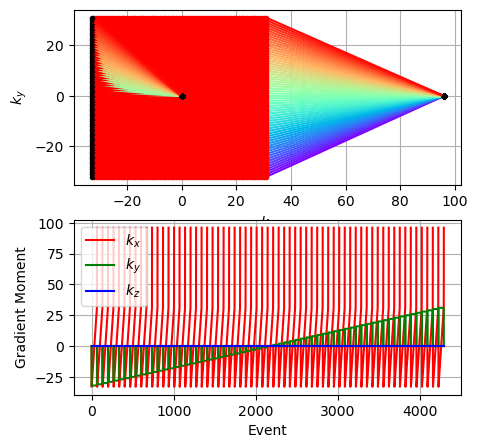

In [9]:
# Build the default FLASH and show the kspace
seq = build_seq()
mr0.plot_kspace_trajectory(seq)

VoxelGridPhantom
FOV: base * rel = tensor([0.1920, 0.1920, 0.1920]) * tensor([1., 1., 1.]) = tensor([0.1920, 0.1920, 0.1920])


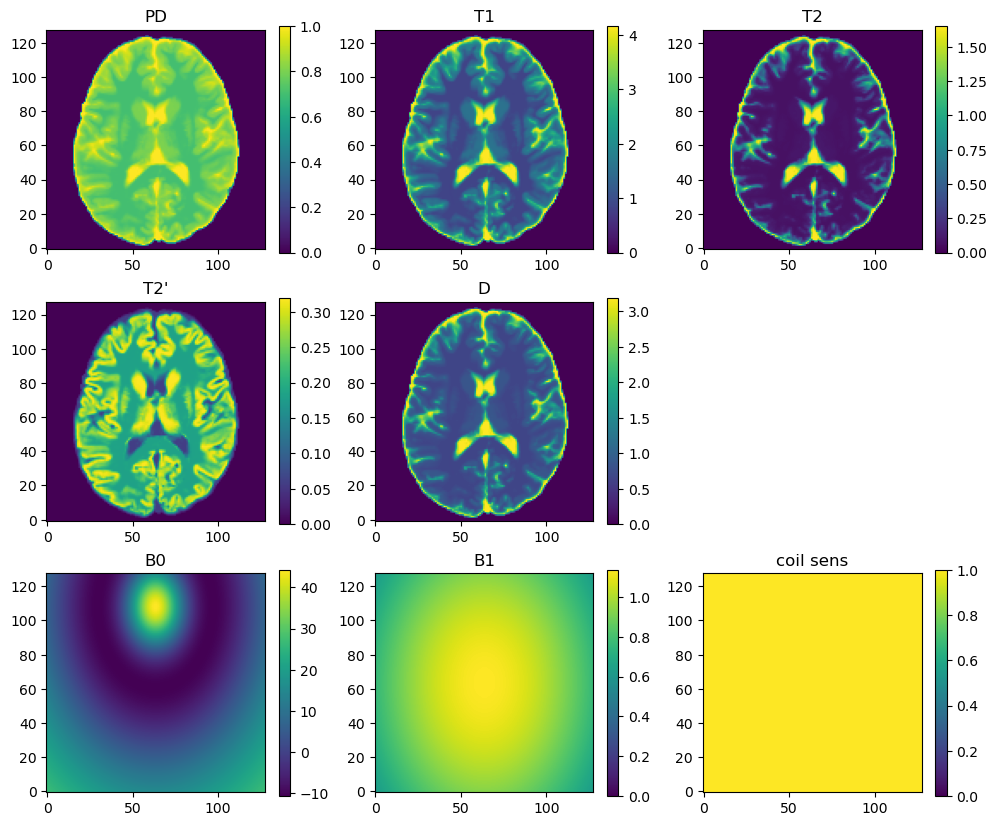

In [10]:
# Load a BrainWeb phantom for simulation

phantom = mr0.VoxelGridPhantom.brainweb("subject05.npz")
phantom = phantom.interpolate(128, 128, 32).slices([16])
phantom.plot()
data = phantom.build()

In [11]:
# Simulate the sequence

graph = mr0.compute_graph(seq, data)
signal = mr0.execute_graph(graph, seq, data)
reco = mr0.reco_adjoint(signal, seq.get_kspace())

Calculating repetition 64 / 64 - done
Detected FOV: (1.0, 1.0, 1.0)
Detected resolution: (64, 64, 1)


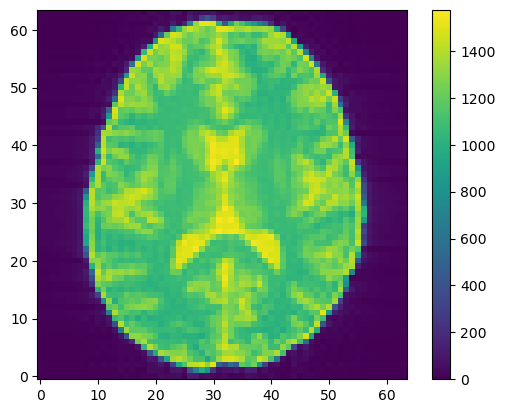

In [12]:
# Plot the result

plt.figure()
plt.imshow(reco.abs().cpu()[:, :, 0].T, origin='lower', vmin=0)
plt.colorbar()
plt.show()